Import Dependencies

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold,learning_curve
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score,make_scorer
import pickle
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from scipy import stats
import matplotlib.colors as mcolors
from matplotlib.colors import BoundaryNorm


Load data into a DataFrame

In [3]:
# Load the data
mb_raw_data = pd.read_csv('../../data/mann_bruker.txt', sep='\t')

# Keep only necessary columns
mb_clean_frame = mb_raw_data[['Sequence', 'm/z', 'CCS','Mass','Charge','Length']]
# Group by 'Sequence' and 'Charge', and calculate median of 'Mass' and 'CCS'
mb_clean_frame = mb_clean_frame.groupby(['Sequence', 'Charge']).agg({'Mass':'median', 'CCS':'median','Length':'median'}).reset_index()
# Perform z-score transformation
mb_clean_frame['CCS_z'] = stats.zscore(mb_clean_frame['CCS'])

# Save the mean and std for later use
ccs_mean = mb_clean_frame['CCS'].mean()
ccs_std = mb_clean_frame['CCS'].std()

# Delete the raw data frame to save memory
del mb_raw_data
# randomize data set
mb_clean_frame = mb_clean_frame.sample(frac=1, random_state=1)

Train Model

In [4]:
# Split the data into input (m/z) and output (CCS) variables
X = mb_clean_frame[['Mass', 'Charge', 'Length']]
y = mb_clean_frame['CCS_z']
# Define the number of folds
k = 4
# Number of trees
n = 50

Perform k-fold cross validation

In [5]:
start_time = time.time()

kf = KFold(n_splits=k)
mse_scores = []
median_relative_errors = []
r2_scores = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model = RandomForestRegressor(n_estimators=n, random_state=1,n_jobs=-1)

    # Train the model
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # Convert predictions back to original scale
    y_pred_orig = y_pred * ccs_std + ccs_mean
    y_test_orig = y_test * ccs_std + ccs_mean


    mse = mean_squared_error(y_test_orig, y_pred_orig)
    mse_scores.append(mse)

    relative_errors = np.abs((y_pred_orig - y_test_orig) / y_test_orig)
    median_relative_error = np.median(relative_errors)
    median_relative_errors.append(median_relative_error)

    r2 = r2_score(y_test_orig, y_pred_orig)
    r2_scores.append(r2)
    # Progress update
    print("Fold:", len(mse_scores))

# Create the final model
final_model = RandomForestRegressor(n_estimators=n, random_state=1,n_jobs=-1)
final_model.fit(X, y)

print("Average Mean Squared Error:", np.mean(mse_scores))
print("Average Median Relative Error:", np.mean(median_relative_errors))
print("Average R^2 Score:", np.mean(r2_scores))
elapsed_time = time.time() - start_time
print(f'Time elapsed: {elapsed_time:.2f} seconds')

Fold: 1
Fold: 2
Fold: 3
Fold: 4
Average Mean Squared Error: 7.318639383493763e-73
Average Median Relative Error: 0.016806985984330156
Average R^2 Score: 0.9890778872004637
Time elapsed: 12.23 seconds


In [7]:

def median_relative_error(y_true, y_pred):
    return np.median(np.abs((y_pred - y_true) / y_true))

scorer = make_scorer(median_relative_error, greater_is_better=False)


In [17]:
train_sizes = np.linspace(0.01, 1.0, 100)

model = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=4)

def median_relative_error(y_true, y_pred):
    y_pred_orig = y_pred * ccs_std + ccs_mean
    y_true_orig = y_true * ccs_std + ccs_mean
    return np.median(np.abs((y_pred_orig - y_true_orig) / y_true_orig))

median_relative_error_scores = []
R2_scores = []
data_sizes = []

for train_size in tqdm(train_sizes):
    kf = KFold(n_splits=k)
    data = mb_clean_frame.sample(frac=train_size, random_state=1)
    X = data[['Mass', 'Charge', 'Length']]
    y = data['CCS_z']
    data_sizes.append(len(data))
    median_relative_errors = []
    r2_scores = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model = RandomForestRegressor(n_estimators=n, random_state=1,n_jobs=-1)
    
        model.fit(X_train, y_train)
    
        y_pred = model.predict(X_test)
    
        y_pred_orig = y_pred * ccs_std + ccs_mean
        y_test_orig = y_test * ccs_std + ccs_mean
    
        
        relative_errors = np.abs((y_pred_orig - y_test_orig) / y_test_orig)
        median_relative_error = np.median(relative_errors)
        median_relative_errors.append(median_relative_error)

        r2 = r2_score(y_test_orig, y_pred_orig)
        r2_scores.append(r2)
    
    median_relative_error_scores.append(np.mean(median_relative_errors))
    R2_scores.append(np.mean(r2_scores))

[0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28
 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41 0.42
 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55 0.56
 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7
 0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83 0.84
 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98
 0.99 1.  ]


100%|██████████| 100/100 [31:26<00:00, 18.86s/it]


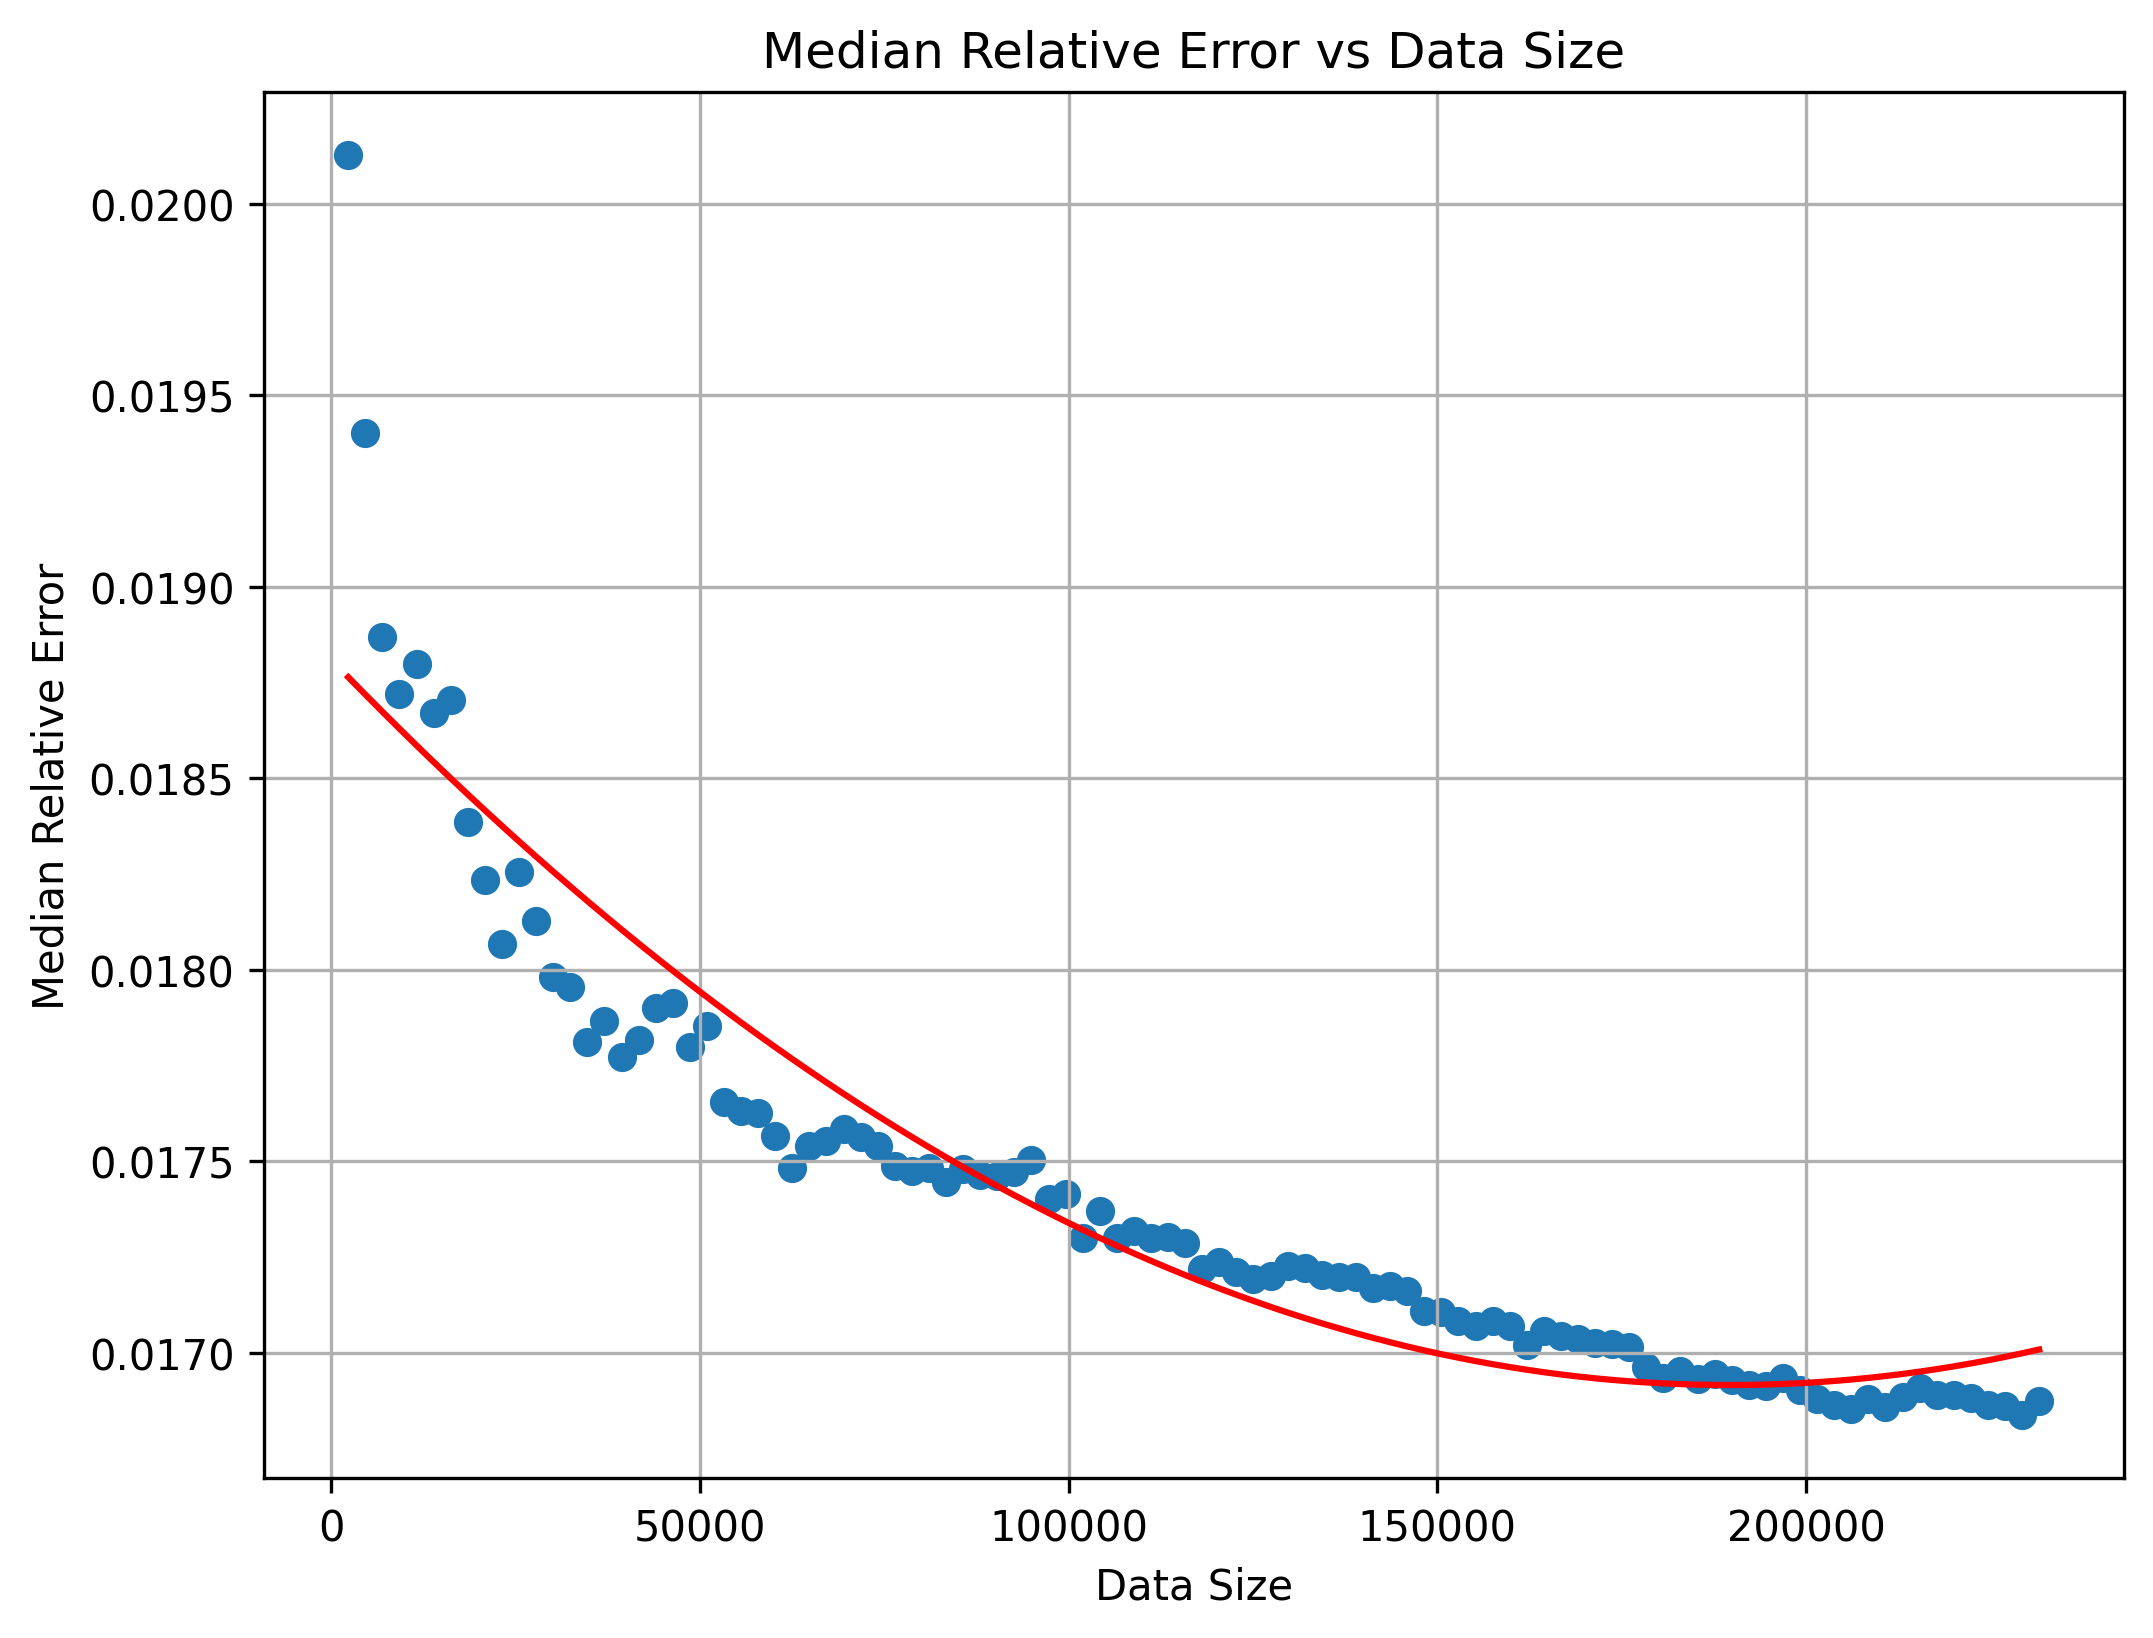

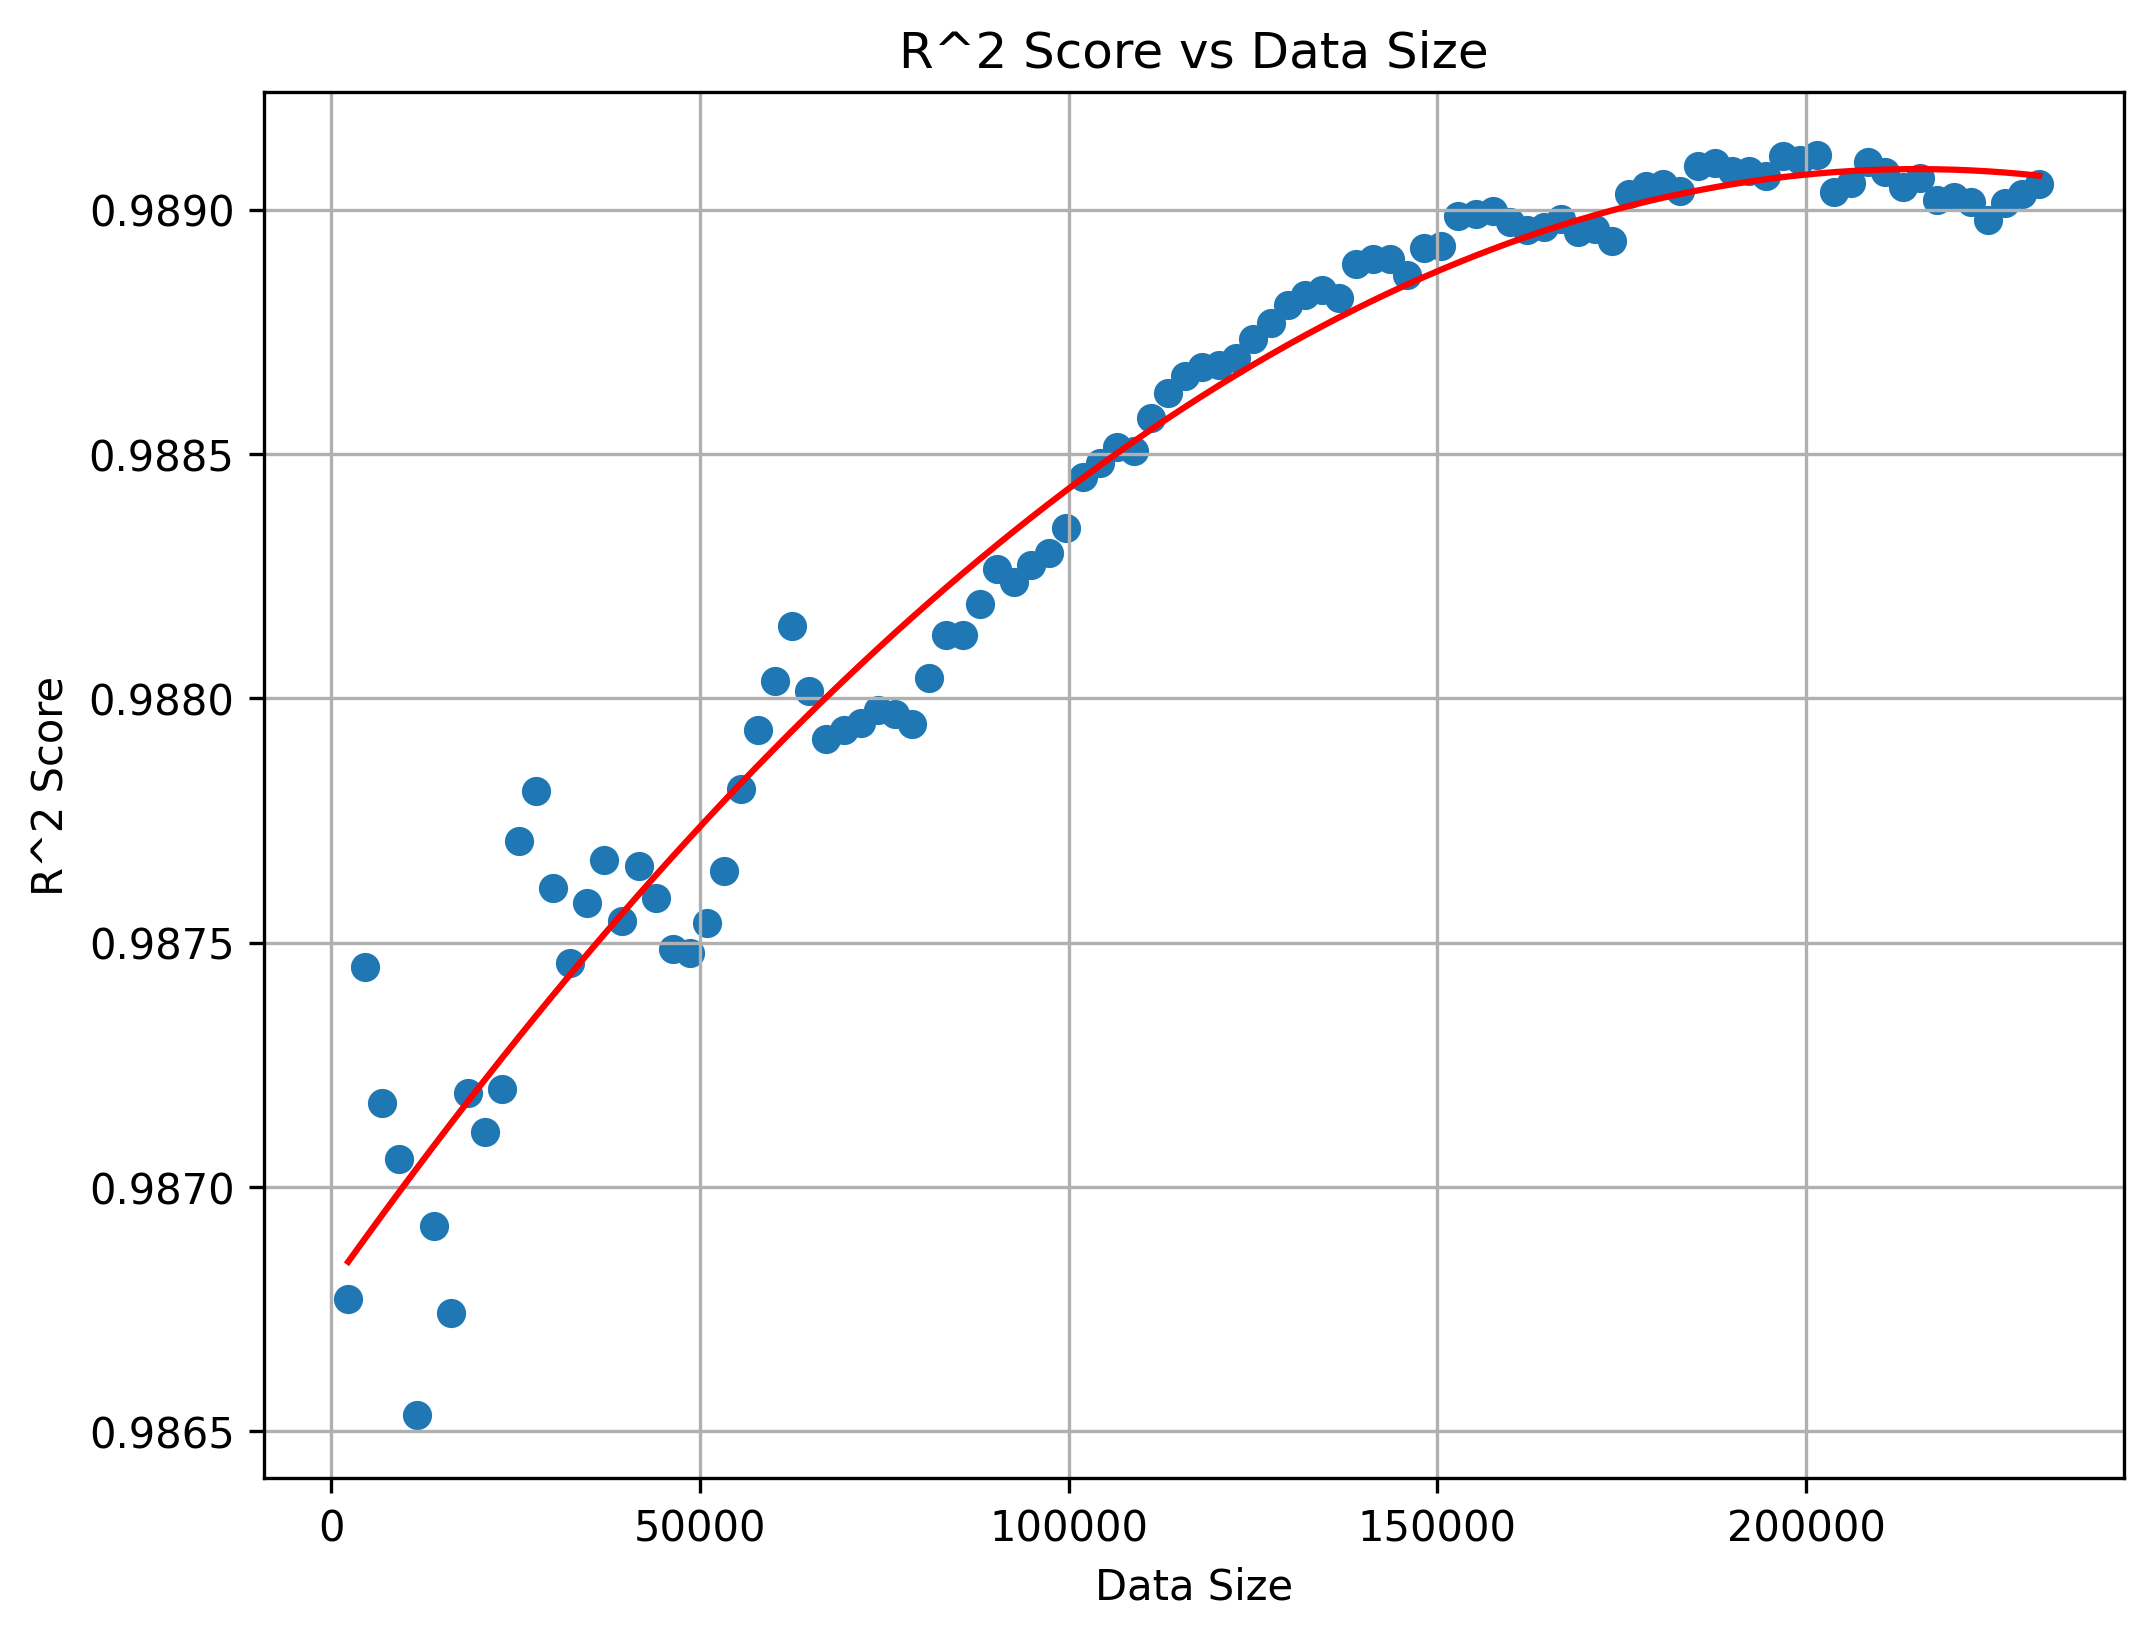

In [23]:
# Plot Median Relative Error with trendline
plt.figure(figsize=(8, 6), dpi=300)
plt.scatter(data_sizes, median_relative_error_scores, marker='o')
coeffs = np.polyfit(data_sizes, median_relative_error_scores, 2)  
poly = np.poly1d(coeffs)
plt.plot(sorted(data_sizes), poly(sorted(data_sizes)), color='red')  
plt.title('Median Relative Error vs Data Size')
plt.xlabel('Data Size')
plt.ylabel('Median Relative Error')
plt.grid(True)
plt.show()

# Plot R^2 Scores with trendline
plt.figure(figsize=(8, 6), dpi=300)
plt.scatter(data_sizes, R2_scores, marker='o')
coeffs = np.polyfit(data_sizes, R2_scores, 2)  
poly = np.poly1d(coeffs)
plt.plot(sorted(data_sizes), poly(sorted(data_sizes)), color='red')  
plt.title('R^2 Score vs Data Size')
plt.xlabel('Data Size')
plt.ylabel('R^2 Score')
plt.grid(True)
plt.show()


Save the model

In [ ]:
# Save the model to a file
#filename = 'random_forest'
#pickle.dump(model, open(filename, 'wb'))

In [6]:
mb_clean_frame['Predicted CCS'] = final_model.predict(X)

# Reverse the z-score transformation
mb_clean_frame['Predicted CCS'] = mb_clean_frame['Predicted CCS'] * ccs_std + ccs_mean


Spearman's Correlation Coefficient: 0.9984545058907338


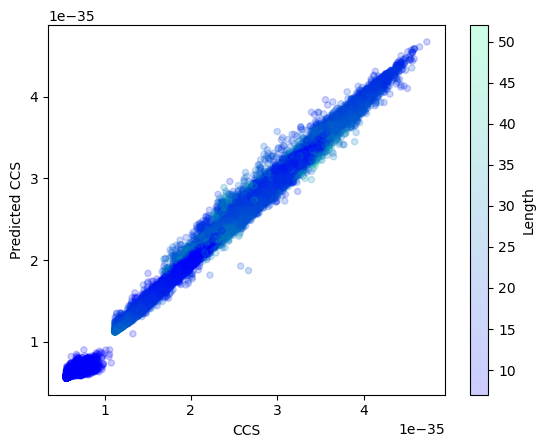

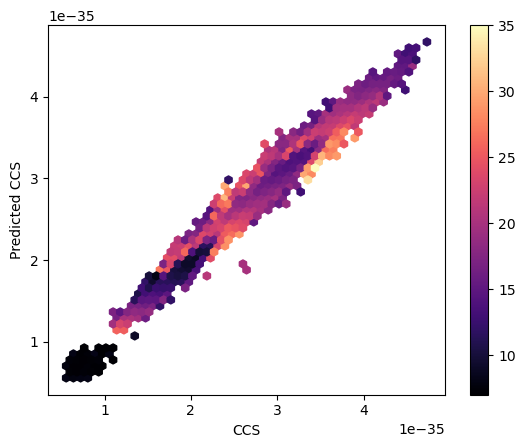

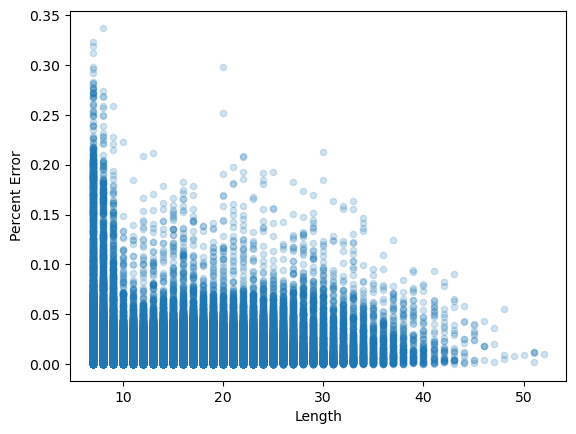

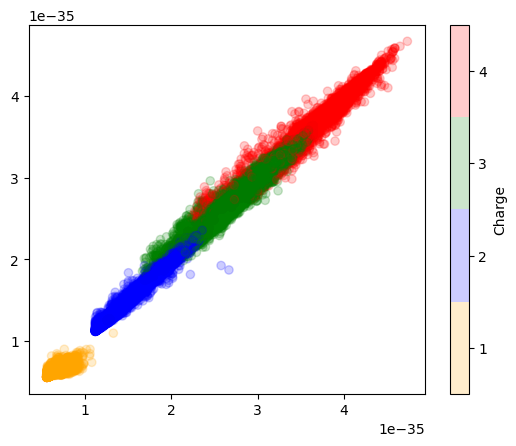

In [21]:

mb_clean_frame.plot.scatter(
    x='CCS',
    y='Predicted CCS',
    c='Length',
    cmap='winter',
    alpha=0.2,
    vmin=mb_clean_frame['Length'].min(),
    vmax=mb_clean_frame['Length'].max()
)
mb_clean_frame.plot.hexbin(
    x='CCS',
    y='Predicted CCS',
    C='Length',
    reduce_C_function=np.mean,
    gridsize=50,
    cmap='magma'
)

# Print the Spearman's correlation coefficient between the predicted and actual CCS values
print("Spearman's Correlation Coefficient:", mb_clean_frame['CCS'].corr(mb_clean_frame['Predicted CCS'], method='spearman'))
# Create a scatter plot between the percent error and length
mb_clean_frame['Percent Error'] = np.abs((mb_clean_frame['Predicted CCS'] - mb_clean_frame['CCS']) / mb_clean_frame['CCS'])
mb_clean_frame.plot.scatter(
    x='Length',
    y='Percent Error',
    alpha=0.2,
    vmin=mb_clean_frame['Length'].min(),
    vmax=mb_clean_frame['Length'].max()
)


boundaries = [0.5, 1.5, 2.5, 3.5, 4.5]
cmap = mcolors.ListedColormap(['orange', 'blue', 'green', 'red'])

norm = BoundaryNorm(boundaries, cmap.N, clip=True)

fig, ax = plt.subplots()

scatter = ax.scatter(
    x=mb_clean_frame['CCS'],
    y=mb_clean_frame['Predicted CCS'],
    c=mb_clean_frame['Charge'],
    cmap=cmap,
    norm=norm,
    alpha=0.2
)

cbar = plt.colorbar(scatter, ticks=[1, 2, 3, 4])
cbar.set_label('Charge')

plt.show()

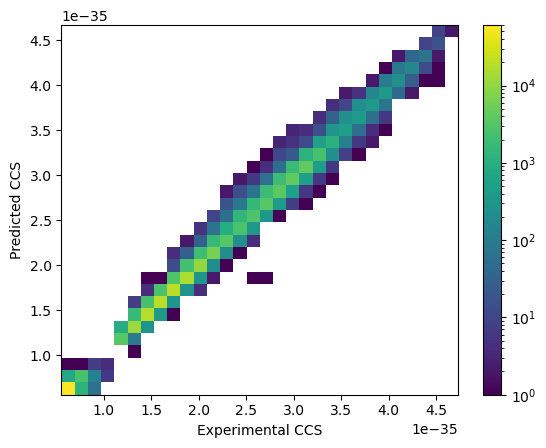

In [23]:
ccs_data = mb_clean_frame["CCS"].to_numpy()
predicted_ccs_data = mb_clean_frame["Predicted CCS"].to_numpy()


x = mb_clean_frame["CCS"]
y = mb_clean_frame["Predicted CCS"]

plt.hist2d(x, y, bins=[30,30],norm=mcolors.LogNorm())
plt.xlabel("Experimental CCS")
plt.ylabel("Predicted CCS")
plt.colorbar()
plt.show()


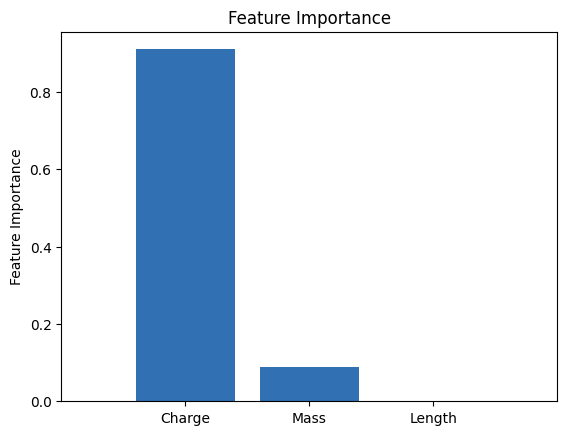

In [7]:
# Get the importances from the final model
importances = final_model.feature_importances_
# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]
features = X.columns

plt.figure()
plt.title("Feature Importance")
plt.bar(range(X.shape[1]), importances[indices], color="#3070B3", align="center")
plt.xticks(range(X.shape[1]), features[indices], rotation=0)
plt.xlim([-1, X.shape[1]])
plt.ylabel('Feature Importance')

plt.show()